**Since it is easier to plot and compute statistics, we convert our Python `sklearn` code to Python, mainly use `glmnet` with sparse matrix.**

The format of `all_mat` is excatly the same as `all_mat` in `lr.py` and `tuning.ipynb`.

# Load the pre-processed data from Python

In [1]:
library('glmnet')
library('Matrix')
library('doMC')
library('caret')
library('elasticnet')
# Use parallel programing
registerDoMC(cores=4)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5

Loading required package: iterators
Loading required package: parallel
Loading required package: lattice
Loading required package: ggplot2
Loading required package: lars
Loaded lars 1.2



In [2]:
# Load the mtx file generated by `python2r.py`
all_mat = readMM('config/matrix.mtx')

In [3]:
# Peek the all_mat
all_mat[1,1:100]
dim(all_mat)

[1] 0.17703553 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
  [7] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [13] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [19] 0.09146226 0.00000000 0.05226831 0.05136623 0.00000000 0.00000000
 [25] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [31] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [37] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [43] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [49] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [55] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [61] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [67] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [73] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [79] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [85] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [91] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [97] 0.00000000 0.00000000 0.00000000 0.00000000

[1] 61153 23617

In [4]:
# Load y_train
y_train = read.csv('../../data/text_train.csv')$stars

In [5]:
y_train[1:100]
length(y_train)

[1] 5 5 1 5 4 3 3 5 2 5 4 3 4 5 4 5 5 5 5 3 5 2 5 5 5 2 5 4 3 4 2 3 5 4 4 2 2
 [38] 4 2 3 2 3 4 5 4 4 2 4 2 2 2 2 2 4 3 1 2 3 2 4 2 3 3 1 3 3 4 2 2 4 1 2 3 5
 [75] 3 4 5 5 4 5 4 5 5 4 5 4 5 5 4 5 4 5 5 5 5 5 5 5 5 4

[1] 36692

In [6]:
# Select x_train from all_mat
TRAIN_LENGTH = length(y_train)
x_train = all_mat[1:36692,]
dim(x_train)

[1] 36692 23617

In [49]:
my_prediction = function(estimator_cv, x_test, output){
    # Make probability prediction
    pred = predict(estimator_cv$glmnet.fit, newx=x_test,
                   s=estimator_cv$lambda.1se, type="response")
    pred_df = data.frame(pred)
    colnames(pred_df) = 1:5
    
    # Trik: use expectation to convert probability into continious values, use lambda function here
    result = apply(X=pred_df, FUN=(function (row) sum(row * 1:5)), MARGIN=1)
    
    # Write the result out as a csv file
    result_df = data.frame(Id=1:dim(x_test)[1], Prediction=result)
    write.csv(result_df, output, row.names=FALSE)
    
    return (result_df)
}
                                   
my_prediction_sub = function(estimator, x_test, lambda, output){
    # Make probability prediction
    pred = predict(estimator, newx=x_test, s=lambda, type="response")
    pred_df = data.frame(pred)
    colnames(pred_df) = 1:5
    
    # Trik: use expectation to convert probability into continious values, use lambda function here
    result = apply(X=pred_df, FUN=(function (row) sum(row * 1:5)), MARGIN=1)
    
    # Write the result out as a csv file
    result_df = data.frame(Id=1:dim(x_test)[1], Prediction=result)
    write.csv(result_df, output, row.names=FALSE)
    
    return (result_df)
}

# Test glmnet (with CV)

In [66]:
# Run this cell if you have stored model
lasso_fit_cv = readRDS("./config/lasso_cv.rsd")

In [14]:
ptm = proc.time()
lasso_fit_cv = cv.glmnet(x_train, y_train, family="multinomial", type.multinomial="grouped",
                         type.measure='mse', lambda=c(1,2,3), 
                         nfolds=5, parallel=TRUE)
proc.time() - ptm

   user  system elapsed 
  5.787   1.940   4.280 

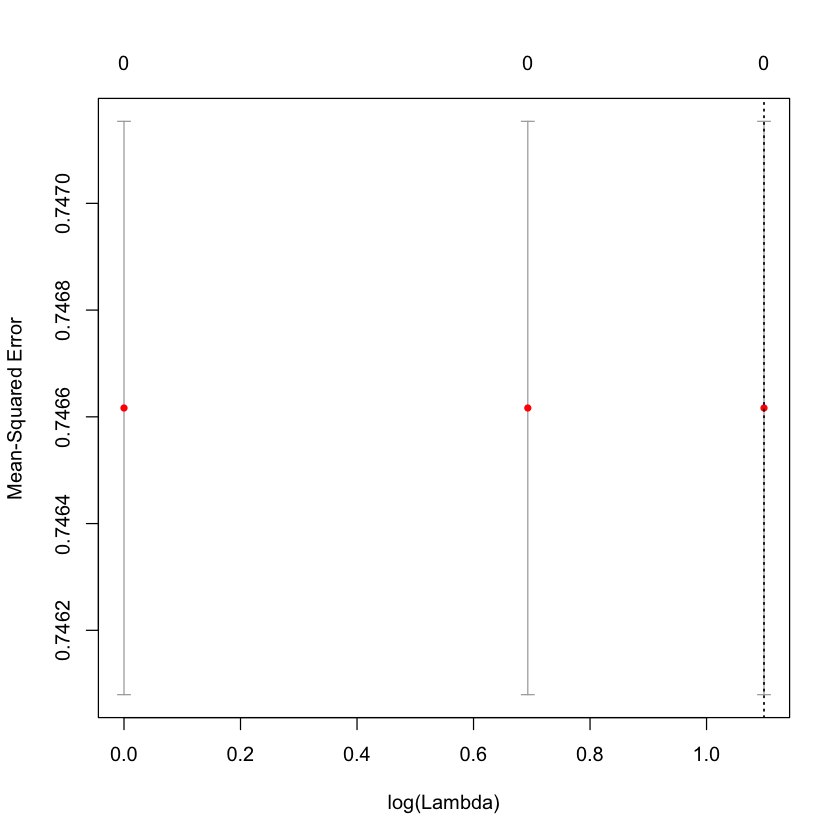

In [15]:
plot(lasso_fit_cv)

(ง •̀_•́)ง We saw a similar result as Python `sklearn`!

# Use glmet to redo the cv grid_search

In [7]:
ptm = proc.time()
lasso_fit_cv = cv.glmnet(x_train, y_train, family="multinomial", type.multinomial="grouped",
                         type.measure='mse', nfolds=5, parallel=TRUE)
proc.time() - ptm

    user   system  elapsed 
6590.423   31.391 3504.788 

It took almost 2 hours to iterate through so many possible $\lambda$. We want to save it.

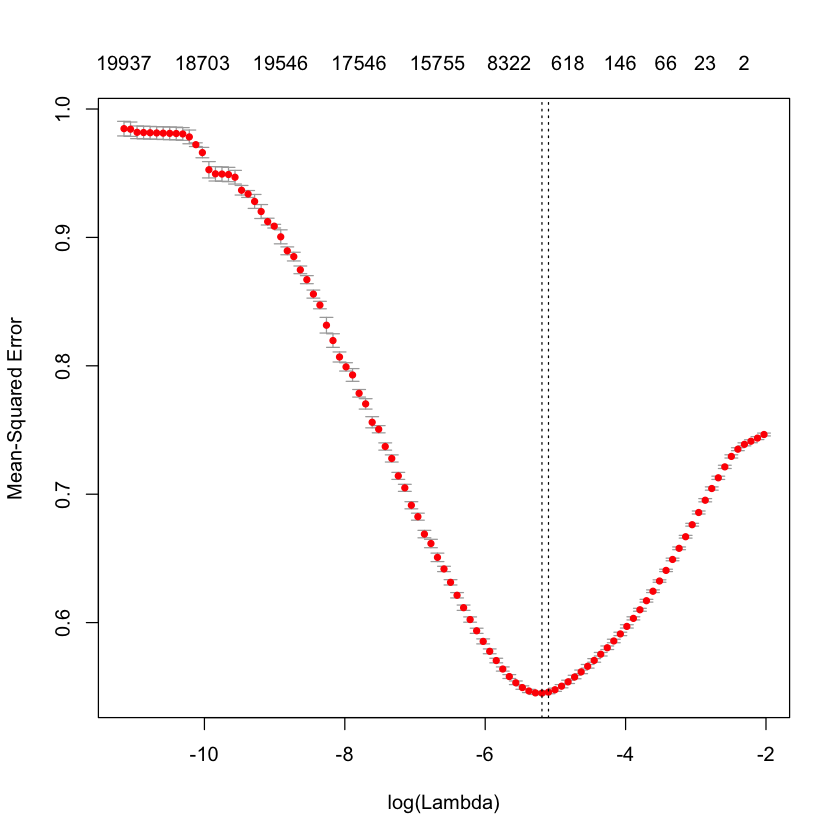

In [9]:
saveRDS(lasso_fit_cv, "./config/lasso_cv.rsd")
plot(lasso_fit_cv)

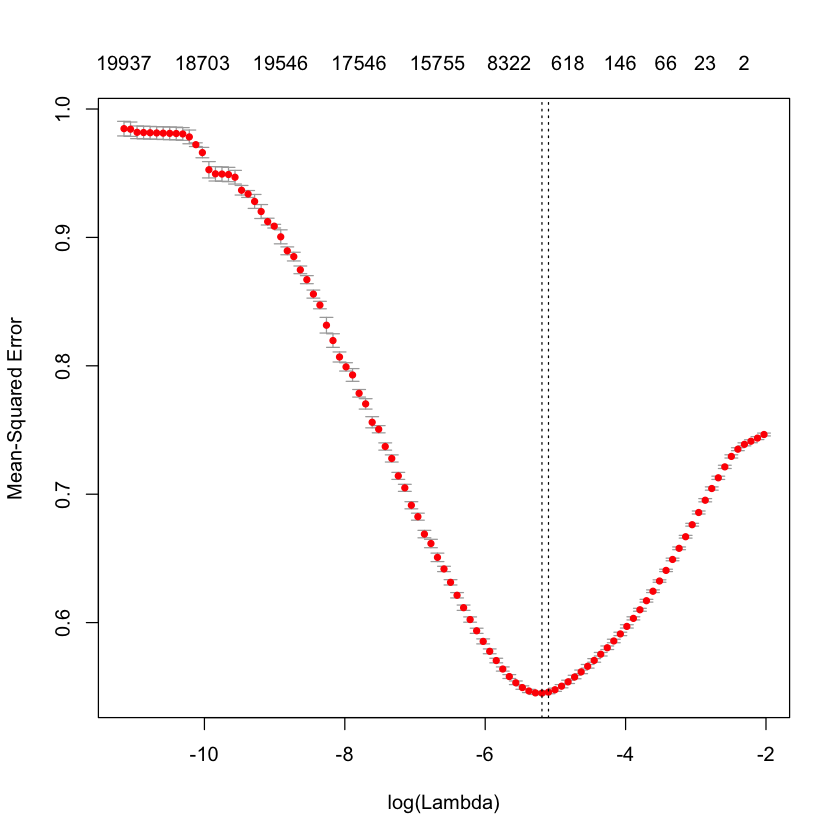

In [15]:
# Test save land load
tt = readRDS("./config/lasso_cv.rsd")
plot(tt)

In [20]:
png('rplot.png')
plot(lasso_fit_cv$glmnet.fit)
dev.off()

pdf 
  2

In [18]:
names(lasso_fit_cv)

[1] "lambda"     "cvm"        "cvsd"       "cvup"       "cvlo"      
 [6] "nzero"      "name"       "glmnet.fit" "lambda.min" "lambda.1se"

In [25]:
?cv.glmnet

## Prediction

In [51]:
x_test = all_mat[36693:dim(all_mat)[1],]
dim(x_test)

[1] 24461 23617

In [60]:
head(my_prediction(lasso_fit_cv, x_test, "./config/prediction_r_lasso.csv"))

Id,Prediction
1,4.019064
2,2.971457
3,4.577829
4,4.255127
5,2.937923
6,1.485147


In [22]:
length(lasso_fit_cv$lambda)

[1] 99

# Feature Selection

In [37]:
lasso_fit = glmnet(x_train, y_train, alpha = 1, lambda = lasso_fit_cv$lambda.min)
# We don't care the intercept coefficient
lasso_coef = coef(lasso_fit)[-1]

In [38]:
lasso_fit$dev.ratio

[1] 0.7019172

In [39]:
lasso_index = which(lasso_coef != 0)
# Select the non-0 coefficient parameters
all_mat_lasso = all_mat[,lasso_index]

# Rebuild the training matrix
x_train_selected = all_mat_lasso[1:TRAIN_LENGTH,]

dim(all_mat_lasso)
dim(x_train_selected)

[1] 61153  4333

[1] 36692  4333

# Use new feature to train a Ridge Classifier

In [15]:
ptm = proc.time()
ridge_fit_cv = cv.glmnet(x_train_selected, y_train, family="multinomial", type.multinomial="grouped",
                         alpha=0, type.measure='mse', nfolds=5, parallel=TRUE)
proc.time() - ptm
saveRDS(lasso_fit_cv, "./config/ridge_cv.rsd")

    user   system  elapsed 
1355.691   10.617  724.267 

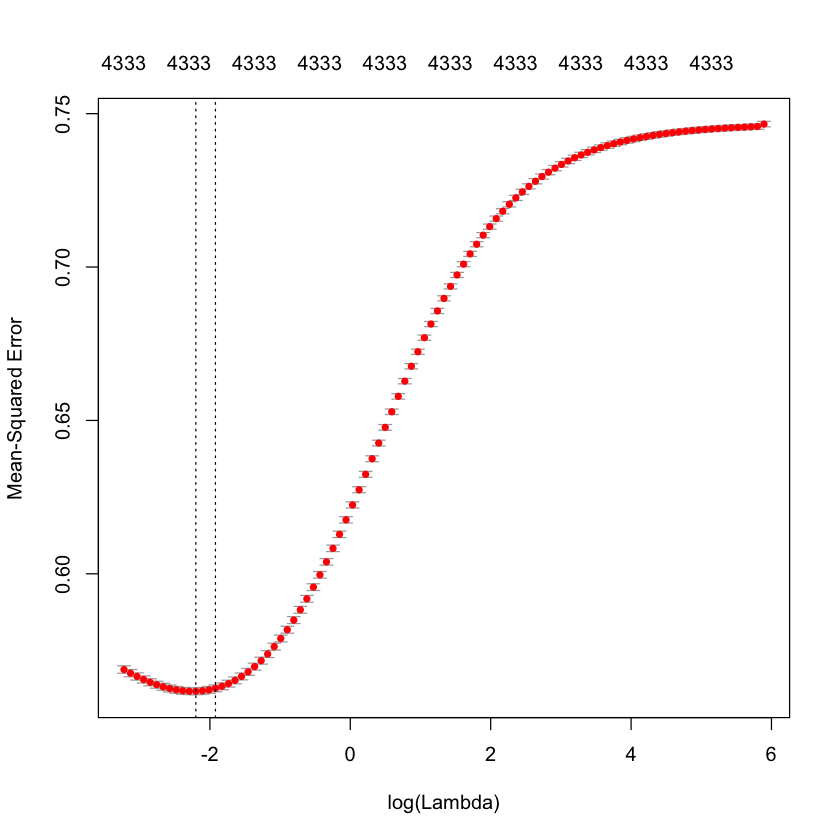

In [16]:
plot(ridge_fit_cv)

In [41]:
x_test_selected = all_mat_lasso[36693 : dim(all_mat_lasso)[1],]

In [40]:
head(my_prediction(ridge_fit_cv, x_test_selected, "./config/prediction_r_ridge.csv"))

ERROR: Error in predict(estimator_cv$glmnet.fit, newx = x_test, s = estimator_cv$lambda.1se, : object 'ridge_fit_cv' not found


# Use new feature to train another lasso

In [11]:
ptm = proc.time()
lasso2_fit_cv = cv.glmnet(x_train_selected, y_train, family="multinomial", type.multinomial="grouped",
                         alpha=1, type.measure='mse', nfolds=5, parallel=TRUE)
proc.time() - ptm
saveRDS(lasso_fit_cv, "./config/lasso2_cv.rsd")

    user   system  elapsed 
5615.330   42.448 2990.147 

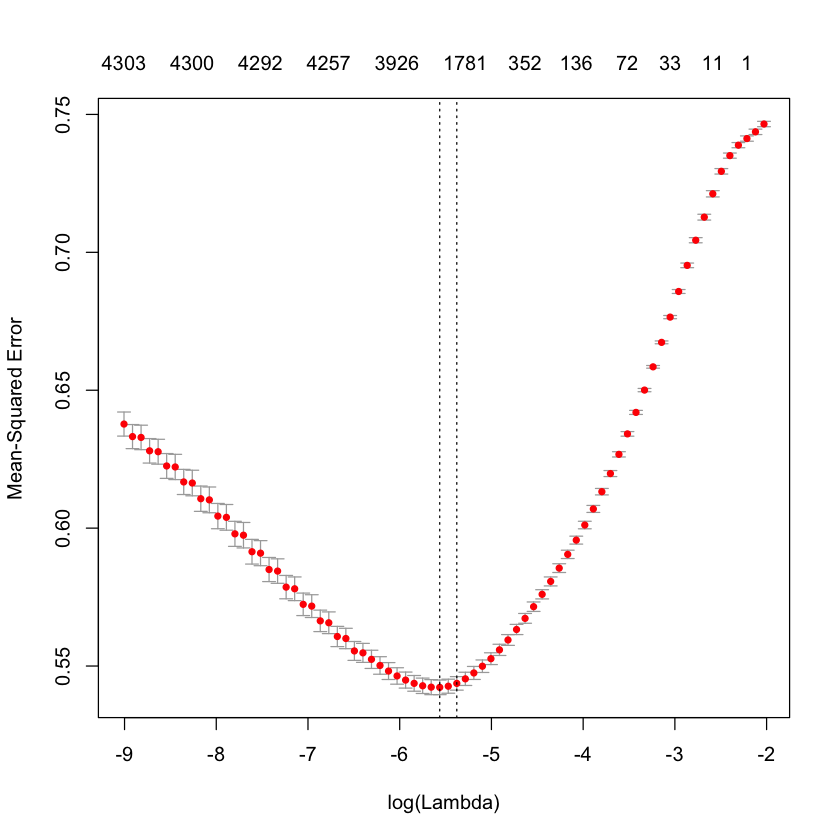

In [12]:
plot(lasso2_fit_cv)

In [24]:
x_test_selected = all_mat_lasso[36693 : dim(all_mat_lasso)[1],]
head(my_prediction(lasso2_fit_cv, x_test_selected, "./config/prediction_r_lasso2.csv"))

Id,Prediction
1,4.062940
2,3.032670
3,4.544619
4,4.283017
5,2.895049
6,1.376037


# Ridge using Python Lasso selected data

In [36]:
# Load the mtx file generated by `python2r.py`
selected_all_mat = readMM('config/selected_matrix.mtx')
dim(selected_all_mat)

[1] 61153  4492

In [35]:
x_train_selected = selected_all_mat[1:TRAIN_LENGTH,]
x_test_selected = selected_all_mat[(TRAIN_LENGTH + 1):dim(selected_all_mat)[1],]

ERROR: Error in eval(expr, envir, enclos): object 'selected_all_mat' not found


In [19]:
ptm = proc.time()
ridge_fit_cv = cv.glmnet(x_train_selected, y_train, family="multinomial", type.multinomial="grouped",
                         alpha=0, type.measure='mse', nfolds=5, parallel=TRUE)
proc.time() - ptm
saveRDS(lasso_fit_cv, "./config/ridge_frompy_cv.rsd")

    user   system  elapsed 
4285.210   40.818 1185.068 

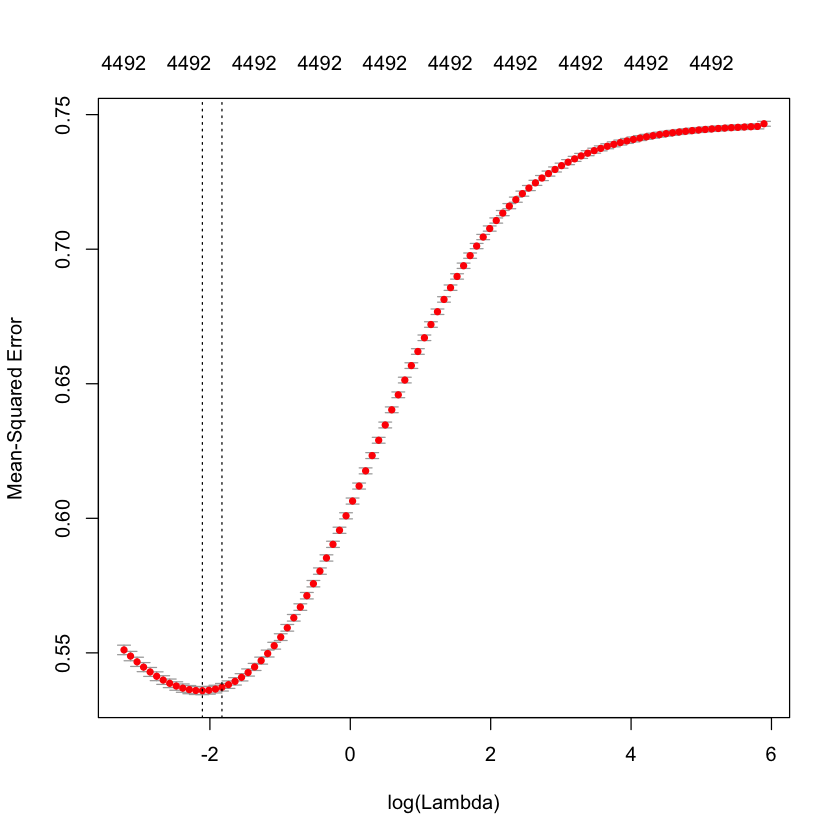

In [20]:
plot(ridge_fit_cv)

In [23]:
head(my_prediction(ridge_fit_cv, x_test_selected, "./config/prediction_r_ridge2.csv"))

Id,Prediction
1,4.289094
2,3.219351
3,4.333791
4,4.304146
5,2.980948
6,2.120256


In [31]:
summary(ridge_fit_cv$glmnet.fit)

           Length Class  Mode     
a0         500    -none- numeric  
beta         5    -none- list     
dfmat      500    -none- numeric  
df         100    -none- numeric  
dim          2    -none- numeric  
lambda     100    -none- numeric  
dev.ratio  100    -none- numeric  
nulldev      1    -none- numeric  
npasses      1    -none- numeric  
jerr         1    -none- numeric  
offset       1    -none- logical  
classnames   5    -none- character
grouped      1    -none- logical  
call         7    -none- call     
nobs         1    -none- numeric  

In [ ]:
test = glmnet()

# Elastic Net

Have trouble to train an elastic net model using sparse matrix.

In [31]:
# We will use caret package to train both parameters
set.seed(333)
ela_cv = train(x = x_train, y = y_train, method = 'glmnet',
               metric = 'RMSE', verbose = TRUE, allowParallel = TRUE)


ERROR: Error: Please use column names for `x`


## Test Second Lasso

In [12]:
lasso2_cv = readRDS("./config/lasso2_cv.rsd")

In [15]:
lasso2_cv$lambda.min

[1] 0.005563782

In [18]:
test = glmnet(x_train_selected, y_train, alpha = 1, lambda = lasso2_cv$lambda.min)

In [20]:
test$df

[1] 4331

## First Lasso

In [21]:
length(lasso_coef)

[1] 23617

In [23]:
abs_coef = abs(lasso_coef)

In [25]:
head(abs_coef)

[1] 0.8913611 0.0000000 0.7150031 0.0000000 0.1191495 0.0000000

In [31]:
coef_index = order(abs_coef, decreasing=TRUE)
coef_index[1:10]
abs_coef[coef_index[1:10]]

[1]  7067   868  3652 19508 12097 12503  7884  2618 13874 23389

[1] 27.872442 15.130355 14.873589 12.162533 11.071009  9.626212  9.358475
 [8]  9.306841  8.780463  8.729287

In [32]:
ptm = proc.time()
lasso2_fit_cv = cv.glmnet(x_train_selected, y_train, family="multinomial", 
                         alpha=1, type.measure='mse', nfolds=5, parallel=TRUE)
proc.time() - ptm
saveRDS(lasso_fit_cv, "./config/lasso3_cv.rsd")

Warning message:
“from glmnet Fortran code (error code -35); Convergence for 35th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”

    user   system  elapsed 
1640.993   14.356 1982.841 

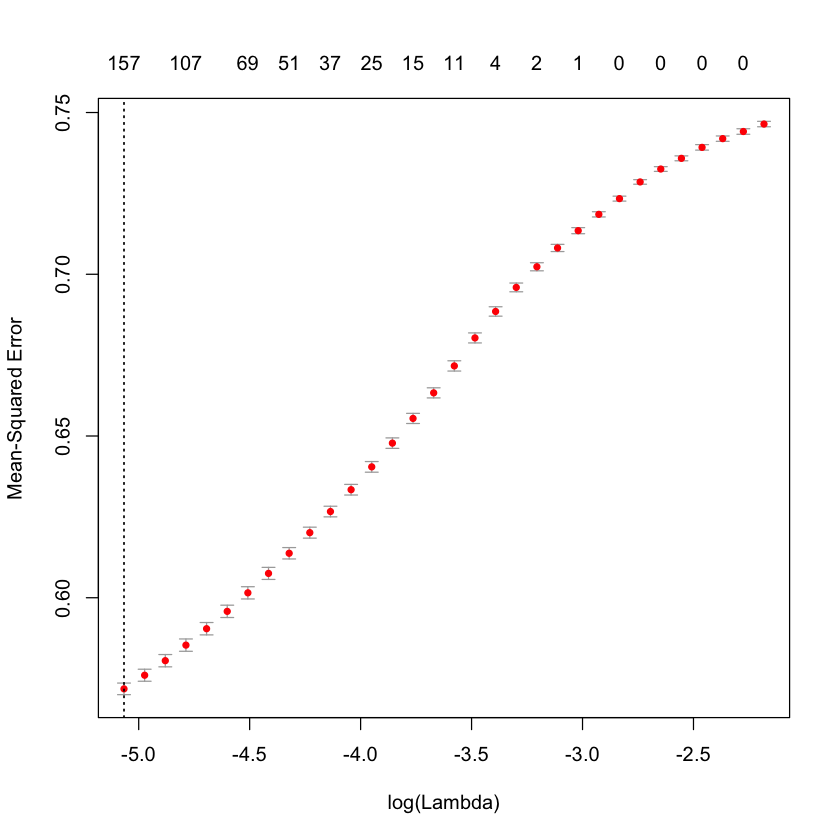

In [33]:
plot(lasso2_fit_cv)

In [42]:
head(my_prediction(lasso2_fit_cv, x_test_selected, "./config/prediction_r_lasso3.csv"))

Id,Prediction
1,3.866401
2,3.011237
3,4.428943
4,4.081643
5,3.122882
6,1.679037


In [52]:
test2 = glmnet(x_train, y_train, alpha=1, lambda=lasso2_fit_cv$lambda.min)
my_prediction_sub(test2, x_test, lasso2_fit_cv$lambda.min, "./config/prediction_r_lasso4.csv")

ERROR: Error in `colnames<-`(`*tmp*`, value = 1:5): 'names' attribute [5] must be the same length as the vector [1]


In [61]:
dim(coef(test2))

[1] 23618     1

In [59]:
head(pred_df)

X1
4.331738
2.904845
4.182829
4.365062
3.263901
1.549085


In [44]:
print(test)


Call:  glmnet(x = x_train_selected, y = y_train, alpha = 1, lambda = lasso2_cv$lambda.min) 

       Df   %Dev   Lambda
[1,] 4331 0.7019 0.005564


# Plot Coefficient Path from Python

In [1]:
library('ggplot2')

In [3]:
cof = read.csv("./config/coe_path.csv", sep = ",", header = TRUE)

In [4]:
head(cof)

X,X0,X1,X2,X3,X4,X5,X6,X7,X8,⋯,X21878,X21879,X21880,X21881,X21882,X21883,X21884,X21885,X21886,X21887
0,0.0000000,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1,-1.1012598,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,-0.9625568,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,-0.9078210,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,-0.8992520,0,0.2933976,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,-0.8645826,0,0.4923925,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [9]:
xx = seq(0.01, 10, length.out=200)

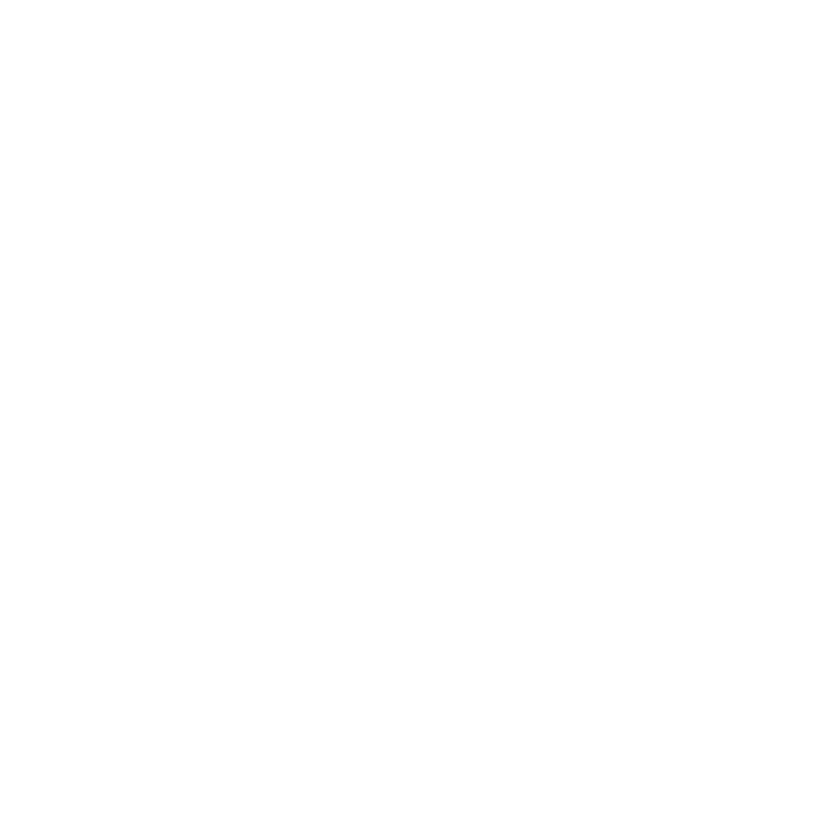

In [12]:
ggplot(cof, aes(x=xx, y=Xo)) + geom_point()

In [18]:
rep(1:3, each=2)

[1] 1 1 2 2 3 3

In [17]:
?rep